<a href="https://colab.research.google.com/github/sowrabh-adiga/cybersec/blob/main/timing_attack_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timing Attack Simulation for Password Cracking
## Introduction
This Jupyter notebook simulates a timing-based side-channel attack to crack a password, inspired by [Daniel Gruss’s YouTube course](https://www.youtube.com/@SideChannelSecurity/playlists) on side-channel attacks as shown in [video: Raiders of the Lost Account](https://youtu.be/V4E_0N_PvW8?si=B6GlHeBmID9tig91). It explores timing differences in a vulnerable password-checking function.


## Background
Timing attacks exploit execution time variations to leak data, as seen in the lecture leading to use the small variations in the execution to a side-channel attack on the PIN entry.

## Methodology
- **Environment**: Google collab, Jupyter
- **Steps**:
  1. Simulated a password check (`unlock`) with bit-by-bit comparison.
  2. Measured execution times over 100,000 trials (and 40 trials per video) to detect correct digits.
  3. Compare the outcomes.

  ## Results
- 500,000 trials(4th cell): Guessed password “9875” correctly atleast in 7/10 iterations , with additional frequency counter implementation.
- 40 trials (video-inspired, last cell): Guessed “1349,” showing challenges with low trials.
- Plot: Frequency of guessed digits for one digit (see below, 3rd cell).

## Discussion
The simulation demonstrates timing-based leakage, relevant to Spectre and CacheWarp. Limitations include no real cache flush and simplified password checking.

## Relevance
Inspired by Gruss’s YouTube course (“Raiders of the Lost Account”) and CoreSec’s work on Spectre, CacheWarp (Kogler), and “Not So Secure TSC” (Sudheendra, Juffinger).

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter

Assume that the site we are trying to acess does password check by comparing bit by bit with entered password and also assume that the below cell is a black box whose contents arent visible to others.

The commented implementation was my attempt to try to understand why delay calculation estimation for the digits had so many variations. Below are my conclusions:



1.   when delay is introduced before checks, the number of iterations required was very low and estimation converged quickly.
2.   But by assuming we dont know how the check is implemented, the worst case scenario would be : theres no delay and we have to solely rely on statistical methods to estimate the key. Therefore the second implementation is commented.



In [2]:
# Black box

# The vulnerable password check function, this cell is assumed to be a external site we are trying to access
password = "9875"

def unlock(key):
    """
    Simulates a password verification process vulnerable to timing attacks.
    """
    if len(key) != len(password):
        return False

    for i in range(len(key)):
        if key[i] == password[i]:
            continue
        else:
            return False
    return True




# def unlock(key):
#   if len(key) != len(password):
#     print("No match ! Hint:Wrong length")
#     return False
#   delay_per_char = 0.00001
#   for i in range(len(key)):
#     time.sleep(delay_per_char)
#     if key[i] == password[i]:
#       continue
#     else:
#       # print(f"passwords not matching, {key}")
#       return False
#   #print("passwords matching")
#   return True

### Below cell has a function to run a single digit simulation and return the best guess

First try with mean resulted im outliers swinging the results very frquently

Just median also swings values but less frequent as compared to mean

In the current approch I combined the median with max occurance in estimates (not mode)

------------------------------


the main idea is :`Record the max value in the list of median delays for each digits`


------------------------------
Approach used to make the results more reliable:

First find median delay for combinations from (0-9) over many trials, then find the max number of times a number has been estimated in the 10 simulations

Starting best-estimate-experiment: 10 runs, each with 500000 trials.
The final result will be the most common guess across all runs.

--- Running Best_Estimate-Experiment Iteration 1/10 ---
Iteration 1 best guess: 9

--- Running Best_Estimate-Experiment Iteration 2/10 ---
Iteration 2 best guess: 1

--- Running Best_Estimate-Experiment Iteration 3/10 ---
Iteration 3 best guess: 9

--- Running Best_Estimate-Experiment Iteration 4/10 ---
Iteration 4 best guess: 9

--- Running Best_Estimate-Experiment Iteration 5/10 ---
Iteration 5 best guess: 5

--- Running Best_Estimate-Experiment Iteration 6/10 ---
Iteration 6 best guess: 9

--- Running Best_Estimate-Experiment Iteration 7/10 ---
Iteration 7 best guess: 9

--- Running Best_Estimate-Experiment Iteration 8/10 ---
Iteration 8 best guess: 3

--- Running Best_Estimate-Experiment Iteration 9/10 ---
Iteration 9 best guess: 9

--- Running Best_Estimate-Experiment Iteration 10/10 ---
Iteration 10 best guess: 9

--- Final Results ---
All guesses 

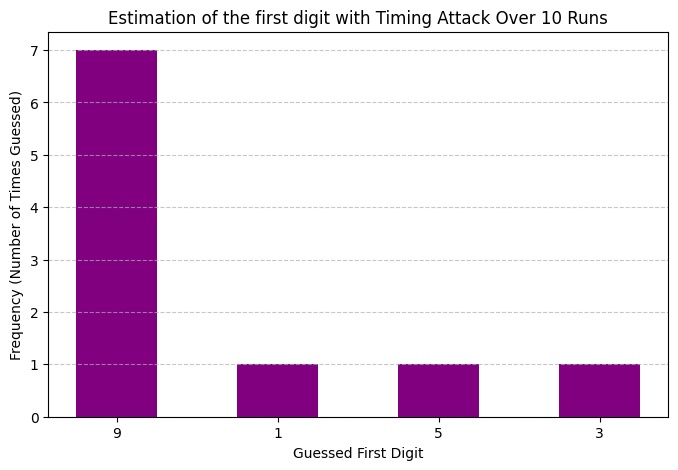

In [3]:
def run_single_simulation(numTrials, passwordLen):
    """Runs a single timing simulation and returns the most likely first digit based on median time.

    Median selected as metric to rule out any outliers due to network or execution latency"""
    medianTimes = {}

    for firstDigit in range(10):
        testKey = str(firstDigit) + "0" * (passwordLen - 1)
        trialTimes = []

        # Using tqdm for a progress bar for each set of trials
        # for _ in tqdm(range(numTrials), desc=f"Testing '{testKey}'"):
        # -->> uncomment above 'for' line and comment the below 'for' line, to see each key combination being used
        for _ in range(numTrials):
            startTime = time.perf_counter()
            unlock(testKey)
            endTime = time.perf_counter()
            trialTimes.append(endTime - startTime)

        medianTimes[testKey] = np.median(trialTimes)

    # Find the key with the highest median time for this run
    estimatedKey = max(medianTimes, key=medianTimes.get)
    return estimatedKey[0] # Return just the digit

# 3. The main "best_estimate-experiment" loop
numTrials = 500000
bestEstimateRuns = 10
allGuesses = []

print(f"Starting best-estimate-experiment: {bestEstimateRuns} runs, each with {numTrials} trials.")
print("The final result will be the most common guess across all runs.\n")

for i in range(bestEstimateRuns):
    print(f"--- Running Best_Estimate-Experiment Iteration {i + 1}/{bestEstimateRuns} ---")
    bestGuess = run_single_simulation(numTrials, len(password))
    allGuesses.append(bestGuess)
    print(f"Iteration {i + 1} best guess: {bestGuess}\n")

# 4. Analyze the results from all the runs
guessCounts = Counter(allGuesses)
mostCommonGuess = guessCounts.most_common(1)[0][0]

print("--- Final Results ---")
print("All guesses from the best--experiment:", allGuesses)
print("Frequency of guesses:", guessCounts)
print(f"\nThe most frequent guess across all {bestEstimateRuns} runs is: '{mostCommonGuess}'")
print(f"The actual first digit of the password is: '{password[0]}'")

# Optional: Plotting the frequency of the guesses
labels, values = zip(*guessCounts.items())
indexes = np.arange(len(labels))
width = 0.5

plt.figure(figsize=(8, 5))
plt.bar(indexes, values, width, color='purple')
plt.xticks(indexes, labels)
plt.xlabel('Guessed First Digit')
plt.ylabel('Frequency (Number of Times Guessed)')
plt.title(f'Estimation of the first digit with Timing Attack Over {bestEstimateRuns} Runs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Below cell has a function to find the full key with same logic as above (logic used for first digit)

One small change here is that the last digit in the key will have low delay as the code exits on finding the correct key. So just for last key we need to record min median value

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---
Most likely digit is: '9'


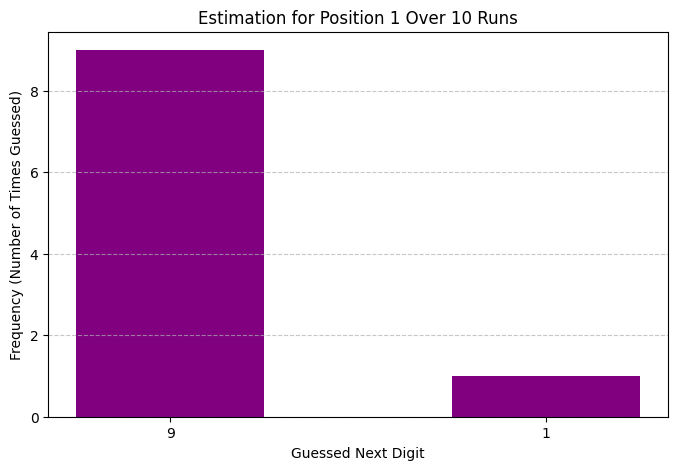

Password so far: '9'

--- Attacking Position 2 (prefix: '9') ---
Most likely digit is: '8'


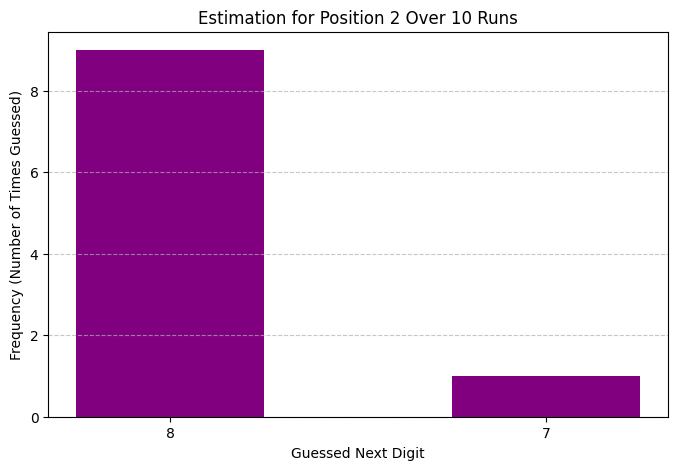

Password so far: '98'

--- Attacking Position 3 (prefix: '98') ---
Most likely digit is: '7'


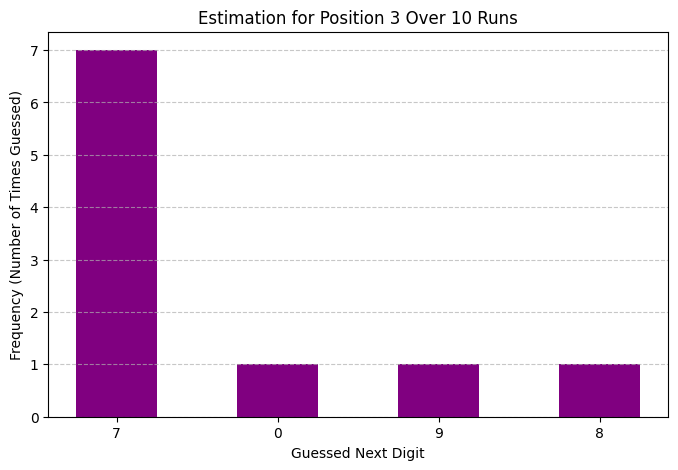

Password so far: '987'

--- Attacking Position 4 (prefix: '987') ---
Most likely digit is: '5'


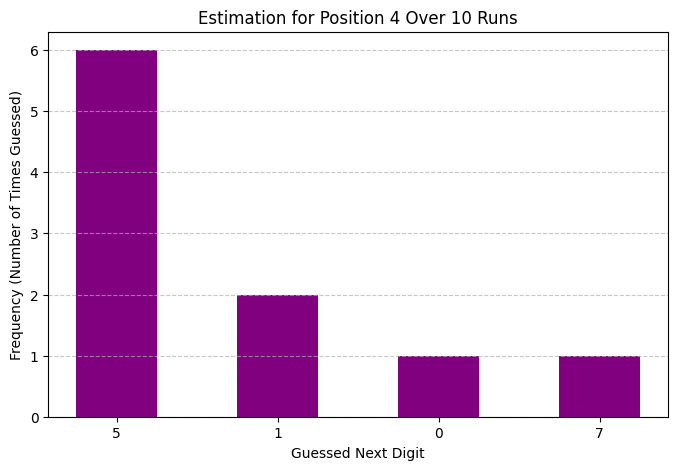

Password so far: '9875'

--- ATTACK SUCCESSFUL ---
The guessed password is: '9875'
The actual password is: '9875'


In [4]:
def find_next_digit(prefix, numTrials, passwordLen):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    allGuesses = []
    bestEstimateRuns = 10 # Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(bestEstimateRuns):
        medianTimes = {}
        for guessDigit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            testKey = prefix + str(guessDigit) + "0" * (passwordLen - (len(prefix) + 1))

            trialTimes = []
            for _ in range(numTrials):
                startTime = time.perf_counter_ns()
                unlock(testKey)
                endTime = time.perf_counter_ns()
                trialTimes.append(endTime - startTime)

            medianTimes[guessDigit] = np.median(trialTimes)
        # Find the key with the highest median time for this single run
        # print(medianTimes)
        if len(prefix) < passwordLen -1:
          estimatedKey = max(medianTimes, key=medianTimes.get)
        else:
          estimatedKey = min(medianTimes, key=medianTimes.get)
        allGuesses.append(estimatedKey)

    # The above logic assumes that for all position other than last one the delay will be large and the delay will be smallest for last digit
    # Use Counter to find the most frequent guess across all meta-runs
    guessCounts = Counter(allGuesses)
    finalGuess = guessCounts.most_common(1)[0][0]
    # print(allGuesses)
    # print(guessCounts)
    print(f"Most likely digit is: '{finalGuess}'")
    # ... (code for finding finalGuess) ...

    # Plot the frequency of the guesses for visualization
    labels, values = zip(*guessCounts.items())
    indexes = np.arange(len(labels))
    width = 0.5

    plt.figure(figsize=(8, 5))
    plt.bar(indexes, values, width, color='purple')
    plt.xticks(indexes, labels)
    plt.xlabel('Guessed Next Digit')
    plt.ylabel('Frequency (Number of Times Guessed)')
    plt.title(f'Estimation for Position {len(prefix) + 1} Over {bestEstimateRuns} Runs')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return str(finalGuess)

    return str(finalGuess)

# Function for sending in each key element for the simulation function
def find_full_password(passwordToCrack, numTrialsPerRun):
    foundPassword = ""
    passwordLen = len(passwordToCrack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(passwordLen):
        nextDigit = find_next_digit(foundPassword, numTrialsPerRun, passwordLen)
        foundPassword += nextDigit
        print(f"Password so far: '{foundPassword}'")

    return foundPassword

# Main body
if __name__ == "__main__":
    numTrialsPerRUN = 100000 # A reasonable number for demonstration for full-scale sweep
    guessedPassword = find_full_password(password, numTrialsPerRUN)
    if len(guessedPassword) == len(password):
      print("\n--- ATTACK SUCCESSFUL ---")
    else:
      print("\n--- ATTACK AVERTED ---")
    print(f"The guessed password is: '{guessedPassword}'")
    print(f"The actual password is: '{password}'")

### Below is the cell implementing code following the instructions on the video for 40 tries and max occurances check is skipped. (changes marked by "<-----" beside it)

In [8]:
def find_next_digit(prefix, numTrials, passwordLen):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    allGuesses = []
    bestEstimateRuns = 1 # <----- Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(bestEstimateRuns):
        medianTimes = {}
        for guessDigit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            testKey = prefix + str(guessDigit) + "0" * (passwordLen - (len(prefix) + 1))

            trialTimes = []
            for _ in range(numTrials):
                startTime = time.perf_counter_ns()
                unlock(testKey)
                endTime = time.perf_counter_ns()
                trialTimes.append(endTime - startTime)

            medianTimes[guessDigit] = np.median(trialTimes)
        # Find the key with the highest median time for this single run
        # print(medianTimes)
        if len(prefix) < passwordLen -1:
          estimatedKey = max(medianTimes, key=medianTimes.get)
        else:
          estimatedKey = min(medianTimes, key=medianTimes.get)
        allGuesses.append(estimatedKey)

    # The above logic assumes that for all position other than last one the delay will be large and the delay will be smallest for last digit
    # Use Counter to find the most frequent guess across all meta-runs
    guessCounts = Counter(allGuesses)
    finalGuess = guessCounts.most_common(1)[0][0]
    # print(allGuesses)
    # print(guessCounts)
    print(f"Most likely digit is: '{finalGuess}'")

    return str(finalGuess)

# Function for sending in each key element for the simulation function
def find_full_password(passwordToCrack, numTrialsPerRun):
    foundPassword = ""
    passwordLen = len(passwordToCrack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(passwordLen):
        nextDigit = find_next_digit(foundPassword, numTrialsPerRun, passwordLen)
        foundPassword += nextDigit
        print(f"Password so far: '{foundPassword}'")

    return foundPassword

# Main body
if __name__ == "__main__":
    numTrialsPerRUN = 40 #<----- A reasonable number for demonstration for full-scale sweep
    guessedPassword = find_full_password(password, numTrialsPerRUN)
    if len(guessedPassword) == len(password):
      print("\n--- ATTACK SUCCESSFUL ---")
    else:
      print("\n--- ATTACK AVERTED ---")
    print(f"The guessed password is: '{guessedPassword}'")
    print(f"The actual password is: '{password}'")

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---
Most likely digit is: '9'
Password so far: '9'

--- Attacking Position 2 (prefix: '9') ---
Most likely digit is: '8'
Password so far: '98'

--- Attacking Position 3 (prefix: '98') ---
Most likely digit is: '7'
Password so far: '987'

--- Attacking Position 4 (prefix: '987') ---
Most likely digit is: '0'
Password so far: '9870'

--- ATTACK SUCCESSFUL ---
The guessed password is: '9870'
The actual password is: '9875'


## Discussion on 40-Trial Results in above cell
The above implentation shows that for low number of tries/iterations the results while close, but not accurate. So, Higher number of tries are required to better estimate the key